# Scalable GP Classification in 1D (w/ KISS-GP)

This example shows how to use grid interpolation based variational classification with an `AbstractVariationalGP` using a `GridInterpolationVariationalStrategy` module. This classification module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

In this example, we’re modeling a function that is periodically labeled cycling every 1/8 (think of a square wave with period 1/4)

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

KISS-GP with SVI for classification was introduced in this paper:
https://papers.nips.cc/paper/6426-stochastic-variational-deep-kernel-learning.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from math import exp

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/gpleiss/anaconda3/envs/gpytorch/lib/python3.7/site-packages/matplotlib/__init__.py:999: UserWarning: Duplicate key in file "/home/gpleiss/.dotfiles/matplotlib/matplotlibrc", line #57
  (fname, cnt))


In [2]:
train_x = torch.linspace(0, 1, 26)
train_y = torch.sign(torch.cos(train_x * (2 * math.pi)))

In [3]:
from gpytorch.models import AbstractVariationalGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import GridInterpolationVariationalStrategy


class GPClassificationModel(AbstractVariationalGP):
    def __init__(self, grid_size=128, grid_bounds=[(0, 1)]):
        variational_distribution = CholeskyVariationalDistribution(grid_size)
        variational_strategy = GridInterpolationVariationalStrategy(self, grid_size, grid_bounds, variational_distribution)
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


model = GPClassificationModel()
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [4]:
from gpytorch.mlls.variational_elbo import VariationalELBO

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# n_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, num_data=train_y.numel())

def train():
    num_iter = 400
    for i in range(num_iter):
        optimizer.zero_grad()
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, num_iter, loss.item()))
        optimizer.step()
        
# Get clock time
%time train()

Iter 1/400 - Loss: 1.416
Iter 2/400 - Loss: 6.308
Iter 3/400 - Loss: 1.661
Iter 4/400 - Loss: 2.645
Iter 5/400 - Loss: 3.797
Iter 6/400 - Loss: 3.026
Iter 7/400 - Loss: 1.811
Iter 8/400 - Loss: 1.248
Iter 9/400 - Loss: 1.638
Iter 10/400 - Loss: 2.314
Iter 11/400 - Loss: 2.120
Iter 12/400 - Loss: 1.658
Iter 13/400 - Loss: 1.406
Iter 14/400 - Loss: 1.384
Iter 15/400 - Loss: 1.697
Iter 16/400 - Loss: 1.562
Iter 17/400 - Loss: 1.542
Iter 18/400 - Loss: 1.575
Iter 19/400 - Loss: 1.089
Iter 20/400 - Loss: 1.141
Iter 21/400 - Loss: 1.178
Iter 22/400 - Loss: 1.190
Iter 23/400 - Loss: 1.254
Iter 24/400 - Loss: 1.126
Iter 25/400 - Loss: 1.201
Iter 26/400 - Loss: 1.019
Iter 27/400 - Loss: 1.325
Iter 28/400 - Loss: 1.096
Iter 29/400 - Loss: 1.051
Iter 30/400 - Loss: 1.087
Iter 31/400 - Loss: 1.243
Iter 32/400 - Loss: 1.382
Iter 33/400 - Loss: 1.190
Iter 34/400 - Loss: 1.073
Iter 35/400 - Loss: 0.978
Iter 36/400 - Loss: 0.959
Iter 37/400 - Loss: 0.908
Iter 38/400 - Loss: 1.044
Iter 39/400 - Loss: 1

Iter 311/400 - Loss: 0.785
Iter 312/400 - Loss: 0.845
Iter 313/400 - Loss: 0.817
Iter 314/400 - Loss: 0.776
Iter 315/400 - Loss: 0.718
Iter 316/400 - Loss: 0.820
Iter 317/400 - Loss: 0.843
Iter 318/400 - Loss: 0.745
Iter 319/400 - Loss: 0.748
Iter 320/400 - Loss: 0.689
Iter 321/400 - Loss: 0.774
Iter 322/400 - Loss: 0.746
Iter 323/400 - Loss: 0.685
Iter 324/400 - Loss: 0.735
Iter 325/400 - Loss: 0.715
Iter 326/400 - Loss: 0.847
Iter 327/400 - Loss: 0.660
Iter 328/400 - Loss: 0.802
Iter 329/400 - Loss: 0.686
Iter 330/400 - Loss: 0.727
Iter 331/400 - Loss: 0.703
Iter 332/400 - Loss: 0.743
Iter 333/400 - Loss: 0.655
Iter 334/400 - Loss: 0.751
Iter 335/400 - Loss: 0.718
Iter 336/400 - Loss: 0.708
Iter 337/400 - Loss: 0.641
Iter 338/400 - Loss: 0.744
Iter 339/400 - Loss: 0.788
Iter 340/400 - Loss: 0.729
Iter 341/400 - Loss: 0.692
Iter 342/400 - Loss: 0.688
Iter 343/400 - Loss: 0.747
Iter 344/400 - Loss: 0.666
Iter 345/400 - Loss: 0.693
Iter 346/400 - Loss: 0.747
Iter 347/400 - Loss: 0.668
I

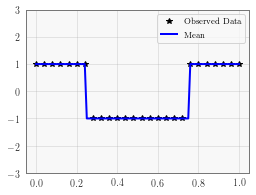

In [5]:
# Set model and likelihood into eval mode
model.eval()
likelihood.eval()

# Initialize axes
f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad():
    test_x = torch.linspace(0, 1, 101)
    predictions = likelihood(model(test_x))

ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
pred_labels = predictions.mean.ge(0.5).float().mul(2).sub(1)
ax.plot(test_x.data.numpy(), pred_labels.numpy(), 'b')
ax.set_ylim([-3, 3])
ax.legend(['Observed Data', 'Mean', 'Confidence'])